<a href="https://colab.research.google.com/github/Patroock/Amazon-Seller/blob/main/Amazon_Seller_c%C3%B3digo_pt.II(TCC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Conexão com o drive para update da base de dados.**

In [2]:
### importando o drive ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importação das bibliotecas**

In [3]:
import pandas as pd #manipulação e análise de dados
import numpy as np #trabalha com computação numérica
import matplotlib.pyplot as plt #Biblioteca para gerar gráficos
import seaborn as sns #Serve para plotagem de gráficos estatísticos
import warnings #biblioteca para controle de avisos
import plotly.express as px #Ferramenta para visualização e compreensão de dados de forma simples e fácil
warnings.simplefilter('ignore') #para não imprimir avisos correspondentes

from wordcloud import wordcloud, STOPWORDS #Ferramenta para visualização de dados
import nltk #para processamento de linguagem natural
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

%matplotlib inline

In [4]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Amazon-Seller(TCC)/AmazonSellers/orders_data.xlsx')

In [6]:
df.shape

(171, 12)

In [7]:
def drop(df, *features):
  for i in features:
    df.drop(i, axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_no      171 non-null    object
 1   order_date    171 non-null    object
 2   buyer         171 non-null    object
 3   ship_city     171 non-null    object
 4   ship_state    171 non-null    object
 5   sku           171 non-null    object
 6   description   171 non-null    object
 7   quantity      171 non-null    int64 
 8   item_total    153 non-null    object
 9   shipping_fee  145 non-null    object
 10  cod           47 non-null     object
 11  order_status  171 non-null    object
dtypes: int64(1), object(11)
memory usage: 16.2+ KB


In [9]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,"CHANDIGARH,",CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,₹449.00,NaN,NaN,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,"PASIGHAT,",ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,₹449.00,₹60.18,NaN,Delivered to buyer


In [10]:
#Convertendo cidade e estado para uppercase
places = ['ship_city', 'ship_state']
for i in places: 
  df[i] = df[i].apply(lambda x: x.upper())

In [11]:
#Removendo comma dos valores das cidades
df['ship_city'] = df['ship_city'].apply(lambda x: x.replace(',',''))
df['ship_state'] = df['ship_state'].apply(lambda x: x.replace(',',''))

In [12]:
df.isnull().sum()

order_no          0
order_date        0
buyer             0
ship_city         0
ship_state        0
sku               0
description       0
quantity          0
item_total       18
shipping_fee     26
cod             124
order_status      0
dtype: int64

In [13]:
#lidando com valores ausentes
# imputing with mode as shipping fee is fixed based on package size and weight
df['shipping_fee'].fillna(df['shipping_fee'].mode()[0], inplace=True)

# imputing with mode as we are considering the item that is sold the most
df['item_total'].fillna(df['item_total'].mode()[0], inplace=True)

# assuming if an order is not cod would mean the mode of payment is online
df['cod'].fillna('online', inplace=True)

In [14]:
#removendo simbolo da rúpia de recursos de quantidade
amounts = ['item_total', 'shipping_fee']
for i in amounts:
    df[i] = df[i].apply(lambda x: x.replace (',', '')) #função que remove as virgulas em quantidades maiores que mil
    df[i] = df[i].apply(lambda x: x[1:])

In [15]:
#mudando os tipos de dados
i = 'int64'
f = 'float64'

df = df.astype( {'item_total' : f, 'shipping_fee': f, 'quantity' : i})

In [16]:
df.head(3)

,order_no,order_date,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status
0,405-9763961-5211537,"Sun, 18 Jul, 2021, 10:38 pm IST",Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer
1,404-3964908-7850720,"Tue, 19 Oct, 2021, 6:05 pm IST",Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer
2,171-8103182-4289117,"Sun, 28 Nov, 2021, 10:20 pm IST",yatipertin,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer


**Distribuição do código**

In [17]:
df [ ['cod', 'order_status', 'item_total']] .groupby (['cod', 'order_status']).sum().reset_index()

,cod,order_status,item_total
0,Cash On Delivery,Delivered to buyer,23812.0
1,Cash On Delivery,Returned to seller,2245.0
2,online,Delivered to buyer,68508.0
3,online,Returned to seller,2694.0


In [18]:
fig = px.histogram(df, x="cod", y="item_total", color = 'order_status', barmode='group', height=500)
fig.show()

**Extraindo ano, mês, dia e hora da tabela de data.**
**Formato Data**

In [19]:
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['date'] = pd.DatetimeIndex(df['order_date']).date
df['time'] = pd.DatetimeIndex(df['order_date']).time
df['month_name'] = pd.DatetimeIndex(df['date']).month_name()
df['day_name'] = pd.DatetimeIndex(df['date']).day_name()

In [20]:
drop(df,'order_date')
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,SKU: 2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,SKU: DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


**Extraindo unico identificador**

In [21]:
df['sku'] = df['sku'].apply(lambda x: x[4: ])
df.head(2)

,order_no,buyer,ship_city,ship_state,sku,description,quantity,item_total,shipping_fee,cod,order_status,year,date,time,month_name,day_name
0,405-9763961-5211537,Mr.,CHANDIGARH,CHANDIGARH,2X-3C0F-KNJE,100% Leather Elephant Shaped Piggy Coin Bank |...,1,449.0,84.96,online,Delivered to buyer,2021,2021-07-18,22:38:00,July,Sunday
1,404-3964908-7850720,Minam,PASIGHAT,ARUNACHAL PRADESH,DN-0WDX-VYOT,Women's Set of 5 Multicolor Pure Leather Singl...,1,449.0,60.18,online,Delivered to buyer,2021,2021-10-19,18:05:00,October,Tuesday


In [22]:
df_sales = df[['date', 'item_total']].groupby('date').sum().reset_index()
df_sales.head(3)

,date,item_total
0,2021-06-13,175.0
1,2021-06-16,525.0
2,2021-06-17,200.0


In [23]:
fig = px.line(df_sales, x = 'date', y="item_total", title = 'Vendas ao longo do periodo')
fig.show()

In [24]:
df_days = df[['year', 'month_name', 'day_name', 'item_total']].groupby (['year', 'month_name', 'day_name']).sum().reset_index() #ordenação de nomes

In [25]:
fig = px.bar(df_days, x ="month_name", y ="item_total", color="day_name", title= "Mês de vendas sábias")
fig.show()

In [26]:
df_places = df[['ship_state','ship_city', 'item_total']].groupby (['ship_state', 'ship_city']).sum().reset_index()
df_places.sort_values(by = 'item_total', ascending =False, inplace=True)

In [27]:
fig = px.sunburst(data_frame=df_places, path=['ship_state', 'ship_city'], values = 'item_total', title = 'Região por ordens')
fig.show()

In [28]:
top_cities = df.groupby('ship_city').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total',ascending=False).head()
fig= px.pie(top_cities, values='Total', names='ship_city',color_discrete_sequence=px.colors.sequential.RdBu, title = 'Top 5 cidades ordenadas')
fig.show()

In [29]:
top_cities = df.groupby('sku').size().reset_index().rename(columns={0: 'Total'}).sort_values('Total',ascending=False).head()
fig = px.pie(top_cities, values='Total', names='sku', color_discrete_sequence=px.colors.sequential.BuGn_r, title='Top 5 de produtos')
fig.show()

In [30]:
df['order_status'].value_counts()

Delivered to buyer    160
Returned to seller     11
Name: order_status, dtype: int64

In [31]:
df_status = df[['order_status','item_total']]
fig = px.bar(data_frame = df_status, x='order_status', y='item_total', color='order_status', title='Rate de sucesso das entregas')
fig.show()

<function matplotlib.pyplot.show>

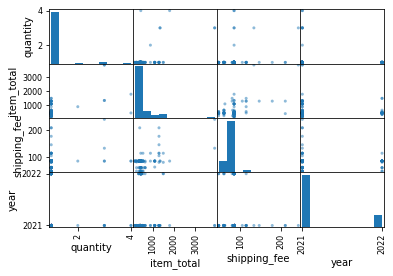

In [32]:
from pandas.plotting import scatter_matrix
scatter_matrix(df)
plt.show

<Figure size 36000x36000 with 0 Axes>

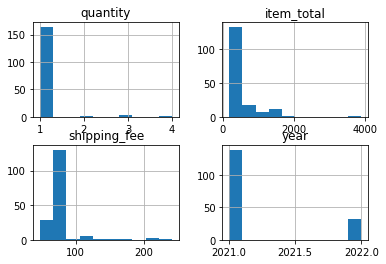

In [33]:
plt.figure(figsize = (500,500))
df.hist()
plt.show()